In [1]:
import mat73
import numpy as np

In [2]:
data_dict = mat73.loadmat("./data/Emotrans1_Boy_data_preprocessed.mat", use_attrdict=True)
arr = np.array(data_dict["All_Feature"])
arr[0][0][0].shape

(18, 128, 8, 2)

In [3]:
#retrive pos or neg return np 
def get_pos_or_neg(data,position):
    arr = []
    index = 0
    for i in range(data.shape[0]):
        temp = []
        for j in position:
            for k in data[i][j[0]][j[1]]:
                temp.append(k)
        arr.append(temp)
    return np.array(arr)

In [4]:
# select frequenceis and (0-4s -> 0 or 0.5-4.5s -> 1)
def get_selected(data=None,freq = None, sec=None):
    if freq:
        data = np.delete(data,freq,axis=3)
    if sec == 0:
        return np.delete(data, 0, axis=4)
    elif sec == 1:
        return np.delete(data,1,axis=4)
    else:
        print('sec not specified')
        return data 

In [5]:

pos = [[0,0],[0,1],[1,2],[1,3],[2,0],[2,1],[2,2],[2,3]]
neg = [[0,2],[0,3],[1,0],[1,1],[3,0],[3,1],[3,2],[3,3]]
pos_df = get_pos_or_neg(arr,pos)
neg_df = get_pos_or_neg(arr,neg)
# print(pos_df.shape)
pos_df=get_selected(pos_df,sec=0).reshape(18,96,128,8)
neg_df = get_selected(neg_df,sec=0).reshape(18,96,128,8)

pos_df.reshape(18,96,128,8).shape

(18, 96, 128, 8)

In [12]:
data_dict_f = mat73.loadmat("./data/Emotrans1_girl_data_preprocessed.mat", use_attrdict=True)
arr_f = np.array(data_dict_f["All_Feature"])
arr_f[0][0][0].shape

(18, 128, 8, 2)

In [6]:
raw_data = np.concatenate((pos_df,neg_df),axis=1).reshape(18,192,128*8)
y = np.concatenate((np.ones((18,96)),np.zeros((18,96))),axis=1)
print(raw_data[0])
print(y[0])
print(raw_data.shape)
print(y.shape)

[[24.76868212  8.28505399 19.89226537 ...  1.34437284  3.21962944
   1.64224947]
 [21.290293    3.12802971  4.72732314 ...  1.48546904  3.94016407
   1.33939938]
 [21.18579229  9.65512501 15.15926869 ...  1.76841957  3.94219625
   1.43962049]
 ...
 [18.41042178 11.37120798 14.89365213 ...  1.18168291  2.79919508
   1.27736176]
 [20.7265142  19.88972494 40.49960878 ...  1.65589367  4.28454831
   1.1988125 ]
 [23.83433906 16.86091234 16.9055344  ...  1.57165314  3.02408346
   1.63899634]]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

In [7]:
print(y.shape)
np.concatenate((y[:5],y[5+1:])).shape

(18, 192)


(17, 192)

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from IPython.display import display
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
# leave one out 
iter = 0
alphas = [0.1,0.01,0.001]
coefs = []
for a in alphas:
    # ,max_iter=int(1e6)
    model = LogisticRegression(C=a, penalty='l1',solver='saga')
    iter = 0
    train_scores=[]
    test_scores = []
    for i in range(17):
        display(iter)
        iter+=1
        x_train,x_test = np.concatenate((raw_data[:i],raw_data[i+1:])).reshape(17*192,1024),raw_data[i].reshape(192,1024)
        y_train,y_test = np.concatenate((y[:i],y[i+1:])).reshape(17*192),y[i].reshape(192)
        x_train,y_train = shuffle(x_train,y_train)
        model.fit(x_train, y_train)
        # training loss
        pred_train_lasso= model.predict(x_train)
        temp = accuracy_score(y_train,pred_train_lasso)
        display("training accuracy: ",temp)
        train_scores.append(temp)

        #testing 
        pred_test_lasso= model.predict(x_test)
        temp = accuracy_score(y_test,pred_test_lasso)
        display("testing accuracy: ",temp)
        test_scores.append(temp)
        
        coefs = model.coef_
    with open('boy_with_acc'+str(a)+".txt",'w') as f:
        f.write("accuracy - training")
        f.write(str(train_scores))
        f.write("\n accuracy - testing")
        f.write(str(test_scores))

        f.write("\ncoefs")
        for c in coefs[0]:
            f.write(str(c)+",")
    print(train_scores)
    print(test_scores)
    print(coefs)

0

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


'training accuracy: '

0.6081495098039216

'testing accuracy: '

0.671875

1

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


'training accuracy: '

0.6121323529411765

'testing accuracy: '

0.6145833333333334

2

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


'training accuracy: '

0.6133578431372549

'testing accuracy: '

0.5364583333333334

3

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


'training accuracy: '

0.6182598039215687

'testing accuracy: '

0.5208333333333334

4

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


'training accuracy: '

0.6053921568627451

'testing accuracy: '

0.5520833333333334

5

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


'training accuracy: '

0.617953431372549

'testing accuracy: '

0.5833333333333334

6

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


'training accuracy: '

0.6185661764705882

'testing accuracy: '

0.6458333333333334

7

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


'training accuracy: '

0.6200980392156863

'testing accuracy: '

0.5572916666666666

8

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


'training accuracy: '

0.6185661764705882

'testing accuracy: '

0.5677083333333334

9

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


'training accuracy: '

0.609375

'testing accuracy: '

0.6979166666666666

10

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


'training accuracy: '

0.6207107843137255

'testing accuracy: '

0.5052083333333334

11

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


'training accuracy: '

0.617953431372549

'testing accuracy: '

0.6041666666666666

12

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


'training accuracy: '

0.6191789215686274

'testing accuracy: '

0.5104166666666666

13

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


'training accuracy: '

0.6182598039215687

'testing accuracy: '

0.5885416666666666

14

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


'training accuracy: '

0.6210171568627451

'testing accuracy: '

0.5416666666666666

15

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


'training accuracy: '

0.6188725490196079

'testing accuracy: '

0.515625

16

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


'training accuracy: '

0.6127450980392157

'testing accuracy: '

0.640625

[0.6081495098039216, 0.6121323529411765, 0.6133578431372549, 0.6182598039215687, 0.6053921568627451, 0.617953431372549, 0.6185661764705882, 0.6200980392156863, 0.6185661764705882, 0.609375, 0.6207107843137255, 0.617953431372549, 0.6191789215686274, 0.6182598039215687, 0.6210171568627451, 0.6188725490196079, 0.6127450980392157]
[0.671875, 0.6145833333333334, 0.5364583333333334, 0.5208333333333334, 0.5520833333333334, 0.5833333333333334, 0.6458333333333334, 0.5572916666666666, 0.5677083333333334, 0.6979166666666666, 0.5052083333333334, 0.6041666666666666, 0.5104166666666666, 0.5885416666666666, 0.5416666666666666, 0.515625, 0.640625]
[[ 2.07893822e-04 -4.97561571e-04 -2.68076329e-09 ... -6.90683334e-05
   4.62382308e-04  4.78129266e-04]]


0

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


'training accuracy: '

0.6032475490196079

'testing accuracy: '

0.6822916666666666

1

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


'training accuracy: '

0.6001838235294118

'testing accuracy: '

0.6510416666666666

2

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


'training accuracy: '

0.6053921568627451

'testing accuracy: '

0.5260416666666666

3

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


'training accuracy: '

0.6047794117647058

'testing accuracy: '

0.5104166666666666

4

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


'training accuracy: '

0.5955882352941176

'testing accuracy: '

0.546875

5

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


'training accuracy: '

0.6044730392156863

'testing accuracy: '

0.6041666666666666

6

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


'training accuracy: '

0.6020220588235294

'testing accuracy: '

0.6510416666666666

7

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


'training accuracy: '

0.6066176470588235

'testing accuracy: '

0.5520833333333334

8

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


'training accuracy: '

0.6087622549019608

'testing accuracy: '

0.5416666666666666

9

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


'training accuracy: '

0.6029411764705882

'testing accuracy: '

0.6875

10

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


'training accuracy: '

0.6035539215686274

'testing accuracy: '

0.5052083333333334

11

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


'training accuracy: '

0.6078431372549019

'testing accuracy: '

0.5677083333333334

12

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


'training accuracy: '

0.6063112745098039

'testing accuracy: '

0.515625

13

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


'training accuracy: '

0.6072303921568627

'testing accuracy: '

0.578125

14

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


'training accuracy: '

0.6044730392156863

'testing accuracy: '

0.5416666666666666

15

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


'training accuracy: '

0.6063112745098039

'testing accuracy: '

0.546875

16

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


'training accuracy: '

0.5992647058823529

'testing accuracy: '

0.6458333333333334

[0.6032475490196079, 0.6001838235294118, 0.6053921568627451, 0.6047794117647058, 0.5955882352941176, 0.6044730392156863, 0.6020220588235294, 0.6066176470588235, 0.6087622549019608, 0.6029411764705882, 0.6035539215686274, 0.6078431372549019, 0.6063112745098039, 0.6072303921568627, 0.6044730392156863, 0.6063112745098039, 0.5992647058823529]
[0.6822916666666666, 0.6510416666666666, 0.5260416666666666, 0.5104166666666666, 0.546875, 0.6041666666666666, 0.6510416666666666, 0.5520833333333334, 0.5416666666666666, 0.6875, 0.5052083333333334, 0.5677083333333334, 0.515625, 0.578125, 0.5416666666666666, 0.546875, 0.6458333333333334]
[[ 0.         -0.0001229   0.         ...  0.          0.00019813
   0.00029635]]


0

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


'training accuracy: '

0.5045955882352942

'testing accuracy: '

0.5

1

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


'training accuracy: '

0.5477941176470589

'testing accuracy: '

0.5208333333333334

2

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


'training accuracy: '

0.5401348039215687

'testing accuracy: '

0.5677083333333334

3

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


'training accuracy: '

0.5431985294117647

'testing accuracy: '

0.59375

4

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


'training accuracy: '

0.5159313725490197

'testing accuracy: '

0.5

5

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


'training accuracy: '

0.5404411764705882

'testing accuracy: '

0.625

6

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


'training accuracy: '

0.5257352941176471

'testing accuracy: '

0.5052083333333334

7

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


'training accuracy: '

0.5560661764705882

'testing accuracy: '

0.5208333333333334

8

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


'training accuracy: '

0.5499387254901961

'testing accuracy: '

0.5208333333333334

9

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


'training accuracy: '

0.5061274509803921

'testing accuracy: '

0.5104166666666666

10

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


'training accuracy: '

0.5533088235294118

'testing accuracy: '

0.484375

11

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


'training accuracy: '

0.5462622549019608

'testing accuracy: '

0.5729166666666666

12

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


'training accuracy: '

0.5143995098039216

'testing accuracy: '

0.5

13

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


'training accuracy: '

0.5337009803921569

'testing accuracy: '

0.515625

14

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


'training accuracy: '

0.5471813725490197

'testing accuracy: '

0.5260416666666666

15

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


'training accuracy: '

0.5297181372549019

'testing accuracy: '

0.5052083333333334

16

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


'training accuracy: '

0.538296568627451

'testing accuracy: '

0.6302083333333334

[0.5045955882352942, 0.5477941176470589, 0.5401348039215687, 0.5431985294117647, 0.5159313725490197, 0.5404411764705882, 0.5257352941176471, 0.5560661764705882, 0.5499387254901961, 0.5061274509803921, 0.5533088235294118, 0.5462622549019608, 0.5143995098039216, 0.5337009803921569, 0.5471813725490197, 0.5297181372549019, 0.538296568627451]
[0.5, 0.5208333333333334, 0.5677083333333334, 0.59375, 0.5, 0.625, 0.5052083333333334, 0.5208333333333334, 0.5208333333333334, 0.5104166666666666, 0.484375, 0.5729166666666666, 0.5, 0.515625, 0.5260416666666666, 0.5052083333333334, 0.6302083333333334]
[[0. 0. 0. ... 0. 0. 0.]]


In [ ]:

# leave one out 
iter = 0
alphas = [0.1,0.01,0.001]
coefs = []
for a in alphas:
    # ,max_iter=int(1e6)
    model = LogisticRegression(C=a, penalty='l1',solver='saga')
    iter = 0
    train_scores=[]
    test_scores = []
    for i in range(17):
        display(iter)
        iter+=1
        x_train,x_test = np.concatenate((raw_data[:i],raw_data[i+1:])).reshape(17*192,1024),raw_data[i].reshape(192,1024)
        y_train,y_test = np.concatenate((y[:i],y[i+1:])).reshape(17*192),y[i].reshape(192)
        x_train,y_train = shuffle(x_train,y_train)
        model.fit(x_train, y_train)
        # training loss
        pred_train_lasso= model.predict(x_train)
        temp = accuracy_score(y_train,pred_train_lasso)
        display("training accuracy: ",temp)
        train_scores.append(temp)

        #testing 
        pred_test_lasso= model.predict(x_test)
        temp = accuracy_score(y_test,pred_test_lasso)
        display("testing accuracy: ",temp)
        test_scores.append(temp)
        
        coefs = model.coef_
    with open('boy_with_acc'+str(a)+".txt",'w') as f:
        f.write("accuracy - training")
        f.write(str(train_scores))
        f.write("\n accuracy - testing")
        f.write(str(test_scores))

        f.write("\ncoefs")
        for c in coefs[0]:
            f.write(str(c)+",")
    print(train_scores)
    print(test_scores)
    print(coefs)

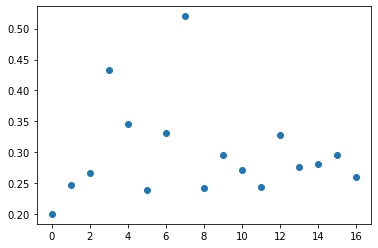

In [39]:
import matplotlib.pyplot as plt
test_scores = [abs(i) for i in test_scores]
plt.scatter(range(len(test_scores)),test_scores)

In [41]:
# model_lasso = Lasso(alpha=0.01)
# model_lasso.fit(X_train, y_train) 
# pred_train_lasso= model_lasso.predict(X_train)
# print(np.sqrt(mean_squared_error(y_train,pred_train_lasso)))
# print(r2_score(y_train, pred_train_lasso))

# pred_test_lasso= model_lasso.predict(X_test)
# print(np.sqrt(mean_squared_error(y_test,pred_test_lasso))) 
# print(r2_score(y_test, pred_test_lasso))


'wefewf'

'e'

In [13]:
# gilrs 
data_dict_female = mat73.loadmat("./data/Emotrans1_girl_data_preprocessed.mat", use_attrdict=True)
arr = np.array(data_dict_female["All_Feature"])

pos_df_f = get_pos_or_neg(arr,pos)
neg_df_f = get_pos_or_neg(arr,neg)
pos_df_f.shape
# pos_df_f=get_selected(pos_df_f,sec=0).reshape(15,96,128,8)
# neg_df_f = get_selected(neg_df_f,sec=0).reshape(15,96,128,8)

(15, 96, 128, 8, 2)

In [10]:
#Import Library
from sklearn import svm
# import numpy as np

X=np.array([
[[25,25,25],[0,0,0],[0,0,0]],
[[25,0,0],[25,0,0],[25,0,0]],
[[75,75,75],[75,75,75],[75,75,75]]])
print(X.shape)
X = X.reshape(X.shape[0], -1)
print(X.shape)
# y=np.array([-1,1,1])


# C=10

# model = svm.SVC(kernel='rbf', C=10, gamma=0.6) 


# model.fit(X, y)
# model.score(X, y)

(3, 3, 3)
(3, 9)


In [15]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
model_lasso = Lasso(alpha=0.01,max_iter=10000)
raw_data = raw_data.reshape(18*192,1024)
y = y.reshape(18*192)
scores = cross_val_score(model_lasso , X = raw_data , y = y , cv = 18)
print(scores)

[ 0.19822949  0.00885607 -0.06400158 -0.73213364 -0.38218785  0.04377508
 -0.32662795 -1.07990036  0.02827607 -0.18232066 -0.08605462  0.02514584
 -0.31081339 -0.10613685 -0.12438524 -0.18144356 -0.04123476 -0.53011623]


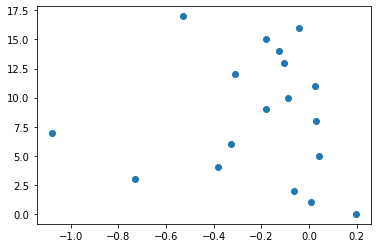

In [44]:
plt.scatter(scores,range(len(scores)))

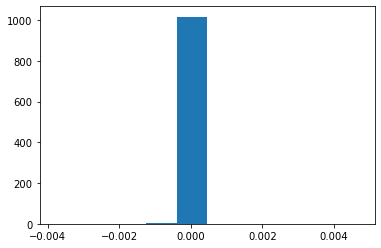

In [6]:
import matplotlib.pyplot as plt
coefs = 0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0047037113889039925,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003744296002722719,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00019332842796502398,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0006714703348514633,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0017899830302762656,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.00379822521887034,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00021624117090692364,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00066361662069106,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002768201670413187,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.00042383306167125483,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.00022599888774521766,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,
plt.hist(coefs)
plt.savefig("coefs_boys01.png")

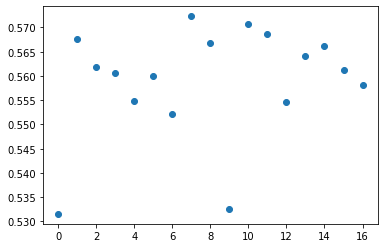

In [12]:
acc = [0.5315563725490197, 0.5677083333333334, 0.5618872549019608, 0.5606617647058824, 0.5548406862745098, 0.5600490196078431, 0.5520833333333334, 0.5723039215686274, 0.5667892156862745, 0.5324754901960784, 0.5707720588235294, 0.5686274509803921, 0.5545343137254902, 0.5640318627450981, 0.5661764705882353, 0.5612745098039216, 0.5582107843137255]
plt.scatter(range(len(acc)),acc)
plt.savefig("acc_train001.png")

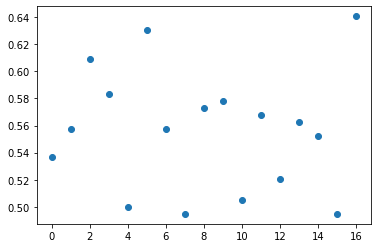

In [13]:
acc = [0.5364583333333334, 0.5572916666666666, 0.609375, 0.5833333333333334, 0.5, 0.6302083333333334, 0.5572916666666666, 0.4947916666666667, 0.5729166666666666, 0.578125, 0.5052083333333334, 0.5677083333333334, 0.5208333333333334, 0.5625, 0.5520833333333334, 0.4947916666666667, 0.640625]
plt.scatter(range(len(acc)),acc)
plt.savefig("acc_test001.png")